<a href="https://colab.research.google.com/github/ZhanyangZhuSD/UCSD_ML/blob/main/Ensembling_Stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction to Ensembling/Stacking in Python
Python · Titanic - Machine Learning from Disaster
[ content link ](https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python/notebook)

Introduction
This notebook is a very basic and simple introductory primer to the method of ensembling (combining) base learning models, in particular the variant of ensembling known as Stacking. In a nutshell stacking uses as a first-level (base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions.

The Titanic dataset is a prime candidate for introducing this concept as many newcomers to Kaggle start out here. Furthermore even though stacking has been responsible for many a team winning Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill somewhat of that void.

I myself am quite a newcomer to the Kaggle scene as well and the first proper ensembling/stacking script that I managed to chance upon and study was one written in the AllState Severity Claims competition by the great Faron. The material in this notebook borrows heavily from Faron's script although ported to factor in ensembles of classifiers whilst his was ensembles of regressors. Anyway please check out his script here:

Stacking Starter : by Faron

Now onto the notebook at hand and I hope that it manages to do justice and convey the concept of ensembling in an intuitive and concise manner. My other standalone Kaggle script which implements exactly the same ensembling steps (albeit with different parameters) discussed below gives a Public LB score of 0.808 which is good enough to get to the top 9% and runs just under 4 minutes. Therefore I am pretty sure there is a lot of room to improve and add on to that script. Anyways please feel free to leave me any comments with regards to how I can improve

In [75]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
# from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold

Feature Exploration, Engineering and Cleaning
Now we will proceed much like how most kernels in general are structured, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [76]:
from google.colab import files
from os.path import exists
def uploadFile(selectedFile):
  file_not_exists = not exists(selectedFile)
  if file_not_exists: 
    print("Upload this file: ", selectedFile)
    uploaded = files.upload()
    file_exists = exists(selectedFile)
    if file_exists: 
      return True
    else:
      return False
  else:
    print("File is ready to read: ", selectedFile)
    return True

In [77]:
selectedTestFile = 'test.csv'
uploadFile(selectedTestFile)

selectedTrainFile = 'train.csv'
uploadFile(selectedTrainFile)

File is ready to read:  test.csv
File is ready to read:  train.csv


True

In [78]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [79]:
# Feature Engineering

full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [80]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

Visualisations

In [81]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


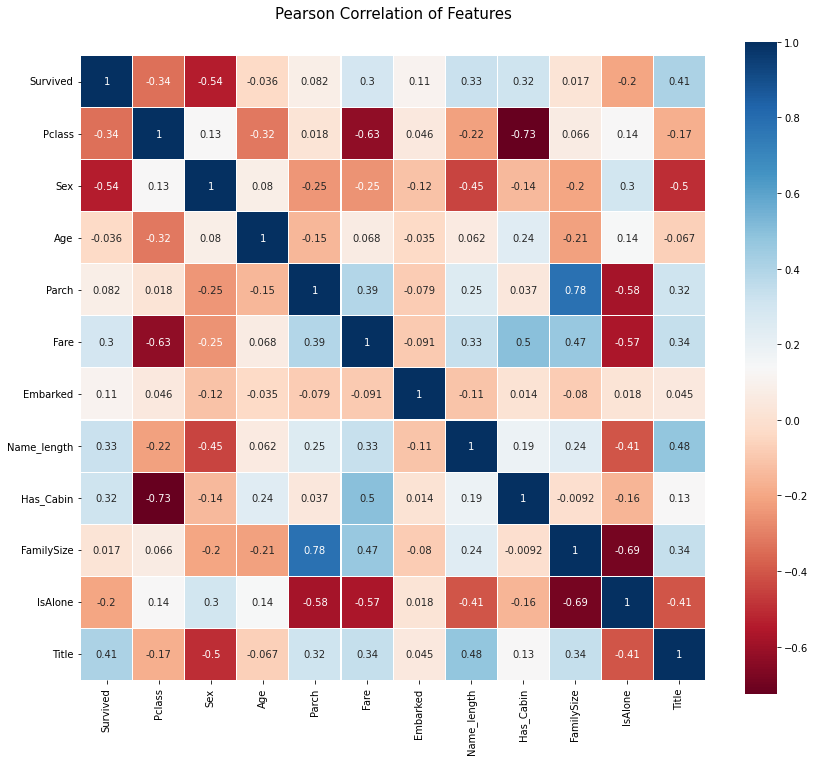

In [82]:
# Pearson Correlation Heatmap
colormap = plt.cm.RdBu
# colormap = plt.cm.gist_heat
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

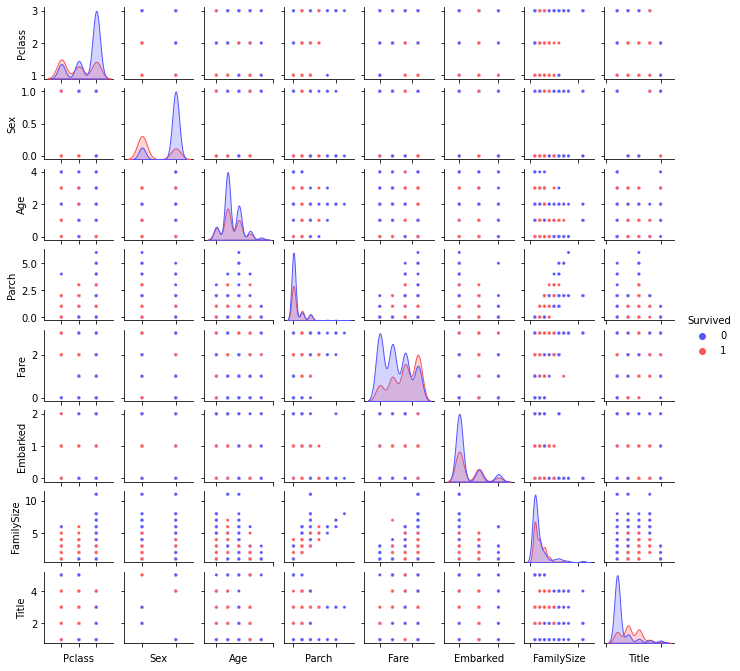

In [83]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

Ensembling & Stacking models

In [84]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
# kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
kf = KFold(n_splits= NFOLDS, shuffle=False, random_state=None)
# kf.get_n_splits(train)
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [86]:
# Out-of-Fold Predictions
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    i=-1
    for (train_index, test_index) in kf.split(x_train):
        i = i + 1
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [87]:
# Generating our Base First-Level Models:
### Random Forest classifier
### Extra Trees classifier
### AdaBoost classifer
### Gradient Boosting classifer
### Support Vector Machine

# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [88]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)


In [90]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [91]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [92]:
# Feature importances generated from the different classifiers
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)
# svc_feature = svc.feature_importances(x_train,y_train)  # 'SVC' object has no attribute 'feature_importances_'

[0.12598745 0.19992691 0.03055107 0.02202535 0.07211632 0.02352258
 0.10839289 0.06355719 0.06858127 0.01351706 0.27182189]
[0.12026371 0.38173181 0.02723465 0.0170405  0.05610406 0.02828957
 0.04714059 0.08204356 0.04619987 0.02209728 0.1718544 ]
[0.026 0.008 0.01  0.066 0.038 0.01  0.706 0.012 0.05  0.006 0.068]
[0.08767195 0.01340548 0.04711516 0.01449965 0.04741118 0.02377538
 0.17427836 0.03697369 0.11214911 0.00790738 0.43481266]


In [93]:
rf_features = [0.12432811, 0.19832426, 0.02928851, 0.02133944, 0.07291973, 0.02388459, 0.10729797, 0.06435839, 0.06876557, 0.01361656, 0.27587687]
et_features = [0.11886348, 0.37528,    0.02746487, 0.01710186, 0.05730366, 0.02883141, 0.04782628, 0.08473772, 0.04538025, 0.02149171, 0.17571877]
ada_features = [0.028, 0.012, 0.016, 0.06,  0.036, 0.01,  0.702, 0.012, 0.052, 0.002, 0.07]
gb_features = [0.0864943,  0.01366369, 0.05138029, 0.01015661, 0.05319087, 0.02452951, 0.17300709, 0.03823823, 0.10960851, 0.00461808, 0.43511281]

In [94]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [96]:
import plotly.io as pio
pio.renderers.default = "colab"

In [97]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [98]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(20)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.124328,0.118863,0.028,0.086494,0.089421
1,Sex,0.198324,0.375280,0.012,0.013664,0.149817
2,Age,0.029289,0.027465,0.016,0.051380,0.031033
3,Parch,0.021339,0.017102,0.060,0.010157,0.027149
4,Fare,0.072920,0.057304,0.036,0.053191,0.054854
5,Embarked,0.023885,0.028831,0.010,0.024530,0.021811
6,Name_length,0.107298,0.047826,0.702,0.173007,0.257533
7,Has_Cabin,0.064358,0.084738,0.012,0.038238,0.049834
8,FamilySize,0.068766,0.045380,0.052,0.109609,0.068939
9,IsAlone,0.013617,0.021492,0.002,0.004618,0.010432


In [99]:
# Plotly Barplot of Average Feature Importances
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

Second-Level Predictions from the First-level Output

In [100]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head(100)

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
95,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0
97,1.0,1.0,1.0,0.0
98,1.0,1.0,1.0,1.0


In [101]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [102]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [103]:
x_train

array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the official documentation.

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [104]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [105]:
# Generate Submission File 
### Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [ ]:
files.view('./')